In [830]:
import pandas as pd
import numpy as np
#from datetime 
import datetime

In [831]:
data=pd.read_csv(r'DataSetforModel1.csv')

In [832]:
data.shape

(629626, 23)

In [833]:
pd.set_option('max_rows',50)
pd.set_option('max_columns',30)

In [834]:
data_inv=data[data['Alpha Rec Code'].isin(['REV_P','PMT'])]

In [835]:
data_inv.shape

(347508, 23)

In [836]:
data_inv['Effective Date']=pd.to_datetime(data_inv['Effective Date'])

D:\python\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [837]:
data_inv=data_inv[data_inv.isOpen==0]

In [838]:
data_inv['Effective Date'].min()

Timestamp('2005-02-25 00:00:00')

In [839]:
data_inv['Effective Date'].max()

Timestamp('2007-10-30 00:00:00')

In [840]:
data_inv['Effective Date'].max()-data_inv['Effective Date'].min()

Timedelta('977 days 00:00:00')

In [841]:
## Dates for M1: 3rd feb 2005 to 30th oct 2007

## Overall variant

In [842]:
rolled_data=data_inv.groupby(['Effective Date'],as_index=False).Amount.sum()

In [843]:
rolled_data.sort_values('Effective Date',inplace=True)

In [844]:
rolled_data.shape

(891, 2)

In [845]:
date_idx=pd.date_range(start=pd.to_datetime('2005-02-25'), end=pd.to_datetime('2007-10-30'), freq='D')

In [846]:
rolled_data2=rolled_data.set_index('Effective Date')

In [847]:
rolled_data2.shape

(891, 1)

In [848]:
rolled_data2=rolled_data2.reindex(date_idx,fill_value=0)

In [849]:
rolled_data2.shape

(978, 1)

In [850]:
rolled_data2['Effective Date'] = rolled_data2.index

In [851]:
rolled_data2 = rolled_data2.reset_index(drop=True)

#### test

In [852]:
test=pd.DataFrame(columns=['Effective Date','Amount'])
test_dates_idx=pd.date_range(start=pd.to_datetime('2007-10-31'), end=pd.to_datetime('2008-04-27'), freq='D')
test=test.reindex(test_dates_idx,fill_value=0)
test['Effective Date'] = test.index
test = test.reset_index(drop=True)

In [853]:
old_rolled=rolled_data2.copy()
rolled_data2=pd.concat([rolled_data2[['Effective Date','Amount']],test],axis=0)

In [854]:
rolled_data2['Effective Date']=pd.to_datetime(rolled_data2['Effective Date'])

In [855]:
rolled_data2.reset_index(inplace=True,drop=True)

#### Perodicity

In [856]:
rolled_data2['day_of_week']=rolled_data2['Effective Date'].dt.dayofweek
rolled_data2['day_of_month']=rolled_data2['Effective Date'].dt.day
rolled_data2['month']=rolled_data2['Effective Date'].dt.month
rolled_data2['quarter']=rolled_data2['Effective Date'].dt.quarter
rolled_data2['week_of_year']=rolled_data2['Effective Date'].dt.week
rolled_data2['week_of_month']=rolled_data2['Effective Date'].apply(lambda d: (d.day-1) // 7 + 1)
rolled_data2['time_since_for_trend']=(rolled_data2['Effective Date']-rolled_data2['Effective Date'].min()).astype(str).apply(lambda x: x.split()[0])
rolled_data2['is_weekend']=np.where((rolled_data2['day_of_week']==5)|(rolled_data2['day_of_week']==6),1,0)
rolled_data2['is_weekday']=np.where((rolled_data2['day_of_week']==5)|(rolled_data2['day_of_week']==6),0,1)

In [857]:
rolled_data2.shape

(1158, 11)

##### sahiti features

In [858]:
temp = rolled_data2

delta_data = data[data['Alpha Rec Code'].isin(['INV','INV_DM'])]

delta_data = delta_data[delta_data['Num Rec Code'] == 21]

delta_data = delta_data[delta_data['isOpen'] ==0]

delta_data['day_of_week']=pd.to_datetime(delta_data['Effective Date']).dt.dayofweek
Invoice_count = delta_data[['ID','day_of_week']].groupby('day_of_week',as_index = False).agg("count")
Invoice_count.columns = ['day_of_week','Invoice_count']


delta_data = pd.merge(delta_data, Invoice_count, on = 'day_of_week', how = 'left')

delta_data['Effective Date'] = pd.to_datetime(delta_data['Effective Date'])

delta_data['delay'] = (pd.to_datetime(delta_data['Clearing Date']) - pd.to_datetime(delta_data['Due Date'])).astype(str).apply(lambda x:x.split()[0]).astype(int)
delta_data['pos_delay'] = np.where(delta_data['delay']>0, delta_data['delay'], 0)

temp['Effective Date'] = temp['Effective Date'].astype(str)
delta_data['Effective Date'] = delta_data['Effective Date'].astype(str)

temp = pd.merge(temp, delta_data[['Effective Date','delay','pos_delay','Invoice_count']], on = 'Effective Date', how = 'left')


temp.drop_duplicates(subset=['Effective Date'], keep='last', inplace=True)

temp['Effective Date'] = pd.to_datetime(temp['Effective Date'])
delta_data['Effective Date'] = pd.to_datetime(delta_data['Effective Date'])

PosDelayByWeekDay = temp[['pos_delay','day_of_week']].groupby('day_of_week',as_index = False).agg("mean")
PosDelayByWeekDay.columns = ['day_of_week','PosDelayByWeekDay']

PosDelayByWeekNo = temp[['pos_delay','week_of_month']].groupby('week_of_month',as_index = False).agg("mean")
PosDelayByWeekNo.columns = ['week_of_month','PosDelayByWeekNo']

PosDelayByMonthNo = temp[['pos_delay','month']].groupby('month',as_index = False).agg("mean")
PosDelayByMonthNo.columns = ['month','PosDelayByMonthNo']

PosDelayByDayOfMonth = temp[['pos_delay','day_of_month']].groupby('day_of_month',as_index = False).agg("mean")
PosDelayByDayOfMonth.columns = ['day_of_month','PosDelayByDayOfMonth']

temp = pd.merge(temp, PosDelayByWeekDay,on='day_of_week' ,how='left')
temp = pd.merge(temp, PosDelayByWeekNo,on ='week_of_month', how = 'left')
temp = pd.merge(temp, PosDelayByMonthNo,on ='month', how = 'left')
temp = pd.merge(temp, PosDelayByDayOfMonth, on = 'day_of_month', how = 'left')

temp["Amount"] = pd.to_numeric(temp["Amount"], downcast='float')

AmountByWeekDay = temp[['Amount','day_of_week']].groupby('day_of_week',as_index = False).agg("mean")
AmountByWeekDay.columns = ['day_of_week','AmountByWeekDay']

AmountByWeekNo = temp[['Amount','week_of_month']].groupby('week_of_month',as_index = False).agg("mean")
AmountByWeekNo.columns = ['week_of_month','AmountByWeekNo']

AmountByMonthNo = temp[['Amount','month']].groupby('month',as_index = False).agg("mean")
AmountByMonthNo.columns = ['month','AmountByMonthNo']

AmountByDayOfMonth = temp[['Amount','day_of_month']].groupby('day_of_month',as_index = False).agg("mean")
AmountByDayOfMonth.columns = ['day_of_month','AmountByDayOfMonth']

temp = pd.merge(temp, AmountByWeekDay,on='day_of_week' ,how='left')
temp = pd.merge(temp, AmountByWeekNo,on ='week_of_month', how = 'left')
temp = pd.merge(temp, AmountByMonthNo,on ='month', how = 'left')
temp = pd.merge(temp, AmountByDayOfMonth, on = 'day_of_month', how = 'left')

rolled_data2=temp

In [859]:
rolled_data2.fillna(0,inplace=True)

#### Holiday based

In [860]:
holidays1=pd.read_csv(r'D:\WORK CODES\cash\Cash Forecasting (For Teams)\HolidaysforModel1 v1.1.csv',header=None)
holidays1.columns=['holidays']
holidays1['holidays']=pd.to_datetime(holidays1['holidays'])
final_holidays_list=list(holidays1['holidays'].dt.date)

In [861]:
#is_holiday, is_weekend_and_holiday, no_of_days_till_next_holiday(w/non-week), no_of_days_past_last_holiday(w/non-week)
rolled_data2['is_holiday']=np.nan
rolled_data2.loc[rolled_data2['Effective Date'].apply(lambda x: True if x.date() in final_holidays_list else False),'is_holiday_boolean']=1
rolled_data2['is_holiday_boolean'].fillna(0,inplace=True)

In [862]:
rolled_data2['weekend_and_holiday']=((rolled_data2['is_holiday_boolean']==1)|(rolled_data2['is_weekend']==1)).astype(int)

In [863]:
rolled_data2.reset_index(inplace=True,drop=True)

In [864]:
rolled_data2['no_of_days_till_next_festival'] = np.nan
rolled_data2['date_time']=pd.to_datetime(rolled_data2['Effective Date']).dt.date
rolled_data2['date_time22']=(rolled_data2['date_time']-rolled_data2['date_time'].min()).apply(lambda x: str(x).split(' ')[0]).astype(int)
rolled_data2=rolled_data2.sort_values('date_time22')
holidays11=rolled_data2[rolled_data2['is_holiday_boolean']==1].sort_values('date_time22')['date_time22'].values.tolist()
rolled_data2.reset_index(drop=True,inplace=True)
rolled_data2['no_of_days_till_next_festival']=np.nan

rolled_data2_index=rolled_data2.index


current_holiday_index=0
for index in rolled_data2_index:
    curr_date = rolled_data2.at[index, 'date_time22']
    if (len(holidays11)==0):
        rolled_data2.at[index, 'no_of_days_till_next_festival']=-1
    else:
        if curr_date<=holidays11[0]:
            rolled_data2.at[index, 'no_of_days_till_next_festival']=holidays11[0]-curr_date
        else:
            holidays11.remove(holidays11[0])
            if (len(holidays11)==0):
                rolled_data2.at[index, 'no_of_days_till_next_festival']=-1
            else:
                rolled_data2.at[index, 'no_of_days_till_next_festival']=holidays11[0]-curr_date

In [865]:
## No of days for All holidays(holidays+weekends)
rolled_data2['no_of_days_till_next_holiday'] = np.nan
holidays_all=rolled_data2[rolled_data2['weekend_and_holiday']==1].sort_values('date_time22')['date_time22'].values.tolist()
rolled_data2.reset_index(drop=True,inplace=True)
holidays_all=sorted(list(set(holidays_all)))
rolled_data2=rolled_data2.sort_values('date_time22')
rolled_data2_index=rolled_data2.index
current_holiday_index=0
for index in rolled_data2_index:
    curr_date = rolled_data2.at[index, 'date_time22']
    if (len(holidays_all)==0):
        rolled_data2.at[index, 'no_of_days_till_next_holiday']=-1
    else:
        if curr_date<=holidays_all[0]:
            rolled_data2.at[index, 'no_of_days_till_next_holiday']=holidays_all[0]-curr_date
        else:
            holidays_all.remove(holidays_all[0])
            if (len(holidays_all)==0):
                rolled_data2.at[index, 'no_of_days_till_next_holiday']=-1
            else:
                rolled_data2.at[index, 'no_of_days_till_next_holiday']=holidays_all[0]-curr_date

In [866]:
## Past holidays
rolled_data2['no_of_days_past_last_festival'] = np.nan
rolled_data2=rolled_data2.sort_values('date_time22')
holidays11=rolled_data2[rolled_data2['is_holiday_boolean']==1].sort_values('date_time22')['date_time22'].values.tolist()
rolled_data2.reset_index(drop=True,inplace=True)
for index in rolled_data2_index:
    curr_date = rolled_data2.at[index, 'date_time22']
    if curr_date<holidays11[0]:
        rolled_data2.at[index, 'no_of_days_past_last_festival']=-1
    elif curr_date==holidays11[0]:
        rolled_data2.at[index, 'no_of_days_past_last_festival']=0
    else:
        rolled_data2.at[index, 'no_of_days_past_last_festival']=curr_date-holidays11[0]
        if (len(holidays11)>1):
            if (holidays11[1]==(curr_date+1)):
                holidays11.remove(holidays11[0])

rolled_data2['no_of_days_past_last_holiday'] = np.nan
holidays_all=rolled_data2[rolled_data2['weekend_and_holiday']==1].sort_values('date_time22')['date_time22'].values.tolist()
rolled_data2.reset_index(drop=True,inplace=True)
holidays_all=sorted(list(set(holidays_all)))
rolled_data2=rolled_data2.sort_values('date_time22')

for index in rolled_data2_index:
    curr_date = rolled_data2.at[index, 'date_time22']
    if curr_date<holidays_all[0]:
        rolled_data2.at[index, 'no_of_days_past_last_holiday']=-1
    elif curr_date==holidays_all[0]:
        rolled_data2.at[index, 'no_of_days_past_last_holiday']=0
        if (len(holidays_all)>1):
            if (holidays_all[1]==(curr_date+1)):
                holidays_all.remove(holidays_all[0])
    else:
        rolled_data2.at[index, 'no_of_days_past_last_holiday']=curr_date-holidays_all[0]
        if (len(holidays_all)>1):
            if (holidays_all[1]==(curr_date+1)):
                holidays_all.remove(holidays_all[0])

In [867]:
rolled_data2['time_since_for_trend']=rolled_data2['time_since_for_trend'].astype(int)

#### Arun features

In [868]:
def quarter_code(x):
    if x.quarter in [1,3]:
        return 0
    elif x.quarter in [2]:
        return 1
    else:
        return 2

def weekofyear_code(x):
    if x.weekofyear in [1,2,3,4,5,6,49,50,51,52]:
        return 0
    elif x.weekofyear in [7,8,9,10,23,24,25,26,27,28,29,30,31,32,33,34,35,36]:
        return 1
    elif x.weekofyear in [11,12,13,14,15,16,17,18,19,20,21,22]:
        return 2
    elif x.weekofyear in [37,38,39]:
        return 3
    elif x.weekofyear in [40,41,42,43,45]:
        return 4
    else:
        return 5

def end_features_code(x):
    if x.is_month_start or x.is_month_end:
        return 1
    elif x.is_quarter_start:
        return 2
    elif x.is_quarter_end:
        return 3
    elif x.is_year_start:
        return 4
    elif x.is_year_end:
        return 5
    else:
        return 0

rolled_data2['arun_quarter']=rolled_data2['Effective Date'].apply(quarter_code).astype(int)
rolled_data2['arun_week_of_year']=rolled_data2['Effective Date'].apply(weekofyear_code).astype(int)
rolled_data2['arun_ending_of_time']=rolled_data2['Effective Date'].apply(end_features_code).astype(int)

In [869]:
rolled_data2['time_since_for_trend']=rolled_data2['time_since_for_trend'].astype(int)

#### seperate data

In [870]:
test=rolled_data2[-180:]
rolled_data2=rolled_data2[:-180]

#### Peak based

In [871]:
rolled_data2_index=rolled_data2.index

In [872]:
# mean/median based - no of days from last peak
rolled_data2['is_peak']=np.where(rolled_data2['Amount']>(rolled_data2['Amount'].median()+(2*rolled_data2['Amount'].std())),1,0)

In [873]:
# no of days from last peak
rolled_data2['no_of_days_from_last_peak']=np.nan
peaks_all=rolled_data2[rolled_data2['is_peak']==1].sort_values('date_time22')['date_time22'].values.tolist()
rolled_data2.reset_index(drop=True,inplace=True)
peaks_all=sorted(list(set(peaks_all)))
rolled_data2=rolled_data2.sort_values('date_time22')

for index in rolled_data2_index:
    curr_date = rolled_data2.at[index, 'date_time22']
    if curr_date<peaks_all[0]:
        rolled_data2.at[index, 'no_of_days_from_last_peak']=-1
    elif curr_date==peaks_all[0]:
        rolled_data2.at[index, 'no_of_days_from_last_peak']=0
        if (len(peaks_all)>1):
            if (peaks_all[1]==(curr_date+1)):
                peaks_all.remove(peaks_all[0])
    else:
        rolled_data2.at[index, 'no_of_days_from_last_peak']=curr_date-peaks_all[0]
        if (len(peaks_all)>1):
            if (peaks_all[1]==(curr_date+1)):
                peaks_all.remove(peaks_all[0])

#### rolling features

In [874]:
for i in range(3, 8):
    rolled_data2['rolling_Amount_mean_' + str(i)] = rolled_data2['Amount'].shift().rolling(i).mean()
    rolled_data2['rolling_Amount_std_' + str(i)] = rolled_data2['Amount'].shift().rolling(i).std()
    rolled_data2['rolling_Amount_mean_' + str(i)] = rolled_data2['rolling_Amount_mean_' + str(i)].fillna(0)
    rolled_data2['rolling_Amount_std_' + str(i)] = rolled_data2['rolling_Amount_std_' + str(i)].fillna(0)

#### shift features

In [875]:
for i in range(1, 6):
    rolled_data2['last_T' + str(i)] = rolled_data2['Amount'].shift(i)
    rolled_data2['last_T' + str(i)] = rolled_data2['last_T' + str(i)].fillna(0)

In [876]:
rolled_data2.shape

(978, 51)

In [877]:
test.shape

(180, 34)

##### last 5 rolling mondays,tues

In [878]:
rolled_data2['rolling_Amount_mean_day_of_week_3']=np.nan
rolled_data2['rolling_Amount_std_day_of_week_3']=np.nan
rolled_data2['rolling_Amount_mean_day_of_week_5']=np.nan
rolled_data2['rolling_Amount_std_day_of_week_5']=np.nan
rolled_data3=pd.DataFrame(columns=rolled_data2.columns.tolist())
for x in rolled_data2['day_of_week'].unique().tolist():
    ks=rolled_data2[rolled_data2['day_of_week']==x]
    ks['rolling_Amount_mean_day_of_week_3'] = ks['Amount'].shift().rolling(3).mean()
    ks['rolling_Amount_std_day_of_week_3'] = ks['Amount'].shift().rolling(3).std()
    ks['rolling_Amount_mean_day_of_week_5'] = ks['Amount'].shift().rolling(5).mean()
    ks['rolling_Amount_std_day_of_week_5'] = ks['Amount'].shift().rolling(5).std()
    ks['rolling_Amount_mean_day_of_week_3'] = ks['rolling_Amount_mean_day_of_week_3'].fillna(0)
    ks['rolling_Amount_std_day_of_week_3'] = ks['rolling_Amount_std_day_of_week_3'].fillna(0)
    ks['rolling_Amount_mean_day_of_week_5'] = ks['rolling_Amount_mean_day_of_week_5'].fillna(0)
    ks['rolling_Amount_std_day_of_week_5'] = ks['rolling_Amount_std_day_of_week_5'].fillna(0)
    ks['last_T1_day_of_week'] = ks['Amount'].shift(1)
    ks['last_T1_day_of_week'] = ks['last_T1_day_of_week'].fillna(0)
    ks['last_T2_day_of_week'] = ks['Amount'].shift(2)
    ks['last_T2_day_of_week'] = ks['last_T2_day_of_week'].fillna(0)
    rolled_data3=pd.concat([rolled_data3,ks],axis=0)
rolled_data2=rolled_data3.sort_values('Effective Date')

D:\python\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\python\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\python\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\python\lib\site-packages

- creating rolling,shift and peak feature while predictions

In [879]:
features=['rolling_Amount_mean_3', 'rolling_Amount_std_4', 'rolling_Amount_mean_5',
          'rolling_Amount_mean_6', 'rolling_Amount_mean_7', 'last_T1', 'last_T4', 'last_T5',
          'day_of_week', 'month', 'is_weekend', 'is_weekday', 'is_holiday_boolean',
          'weekend_and_holiday', 'no_of_days_till_next_holiday', 'no_of_days_past_last_festival']

In [ ]:
M2=['rolling_Amount_mean_3', 'rolling_Amount_std_3', 'rolling_Amount_std_5', 
    'rolling_Amount_std_7', 'last_T2', 'last_T3', 'last_T4', 'day_of_week', 
    'day_of_month', 'month', 'quarter', 'week_of_year', 'is_weekend', 'is_weekday',
    'no_of_days_past_last_festival', 'rolling_Amount_mean_day_of_week_5', 
    'rolling_Amount_std_day_of_week_3', 'rolling_Amount_std_day_of_week_5', 'last_T1_day_of_week']

In [823]:
features=['rolling_Amount_mean_5', 'last_T2','day_of_week','is_weekday', 'is_holiday_boolean','weekend_and_holiday',
          'no_of_days_till_next_holiday', 'no_of_days_from_last_peak','rolling_Amount_mean_day_of_week_5',
          'rolling_Amount_std_day_of_week_5','last_T2_day_of_week',
          'Invoice_count','AmountByWeekDay']

In [654]:
features=['rolling_Amount_mean_3','rolling_Amount_std_3', 'rolling_Amount_mean_4', 'rolling_Amount_std_4',
          'rolling_Amount_mean_5', 'rolling_Amount_std_5','rolling_Amount_mean_6', 'rolling_Amount_std_6',
          'rolling_Amount_mean_7', 'rolling_Amount_std_7', 'last_T1', 'last_T2','last_T3', 'last_T4', 'last_T5','day_of_week',
          'day_of_month', 'month','quarter', 'week_of_year', 'week_of_month', 'time_since_for_trend','is_weekend',
          'is_weekday', 'is_holiday_boolean','weekend_and_holiday','no_of_days_till_next_festival', 
          'no_of_days_till_next_holiday','no_of_days_past_last_festival','no_of_days_past_last_holiday', 
          'no_of_days_from_last_peak','rolling_Amount_mean_day_of_week_3','rolling_Amount_mean_day_of_week_5',
          'rolling_Amount_std_day_of_week_3','rolling_Amount_std_day_of_week_5',
          'last_T2_day_of_week','last_T1_day_of_week','arun_quarter','arun_week_of_year','arun_ending_of_time',
         'PosDelayByWeekDay','PosDelayByWeekNo','PosDelayByMonthNo','PosDelayByDayOfMonth',
          'Invoice_count','AmountByWeekDay','AmountByWeekNo','AmountByMonthNo','AmountByDayOfMonth']

In [655]:
features=['rolling_Amount_mean_3', 'rolling_Amount_std_4', 'rolling_Amount_mean_5',
          'rolling_Amount_mean_6', 'rolling_Amount_mean_7', 'last_T1', 'last_T4', 'last_T5',
          'day_of_week', 'month', 'is_weekend', 'is_weekday', 'is_holiday_boolean',
          'weekend_and_holiday', 'no_of_days_till_next_holiday', 'no_of_days_past_last_festival','PosDelayByWeekDay',
          'PosDelayByWeekNo','PosDelayByMonthNo','PosDelayByDayOfMonth',
          'Invoice_count','AmountByWeekDay','AmountByWeekNo','AmountByMonthNo','AmountByDayOfMonth']

In [329]:
features=['rolling_Amount_mean_3', 'rolling_Amount_std_4', 'rolling_Amount_mean_5',
          'rolling_Amount_mean_6', 'rolling_Amount_mean_7', 'last_T1', 'last_T4', 'last_T5',
          'day_of_week', 'month', 'is_weekend', 'is_weekday', 'is_holiday_boolean',
          'weekend_and_holiday', 'no_of_days_till_next_holiday', 'no_of_days_past_last_festival',
          'rolling_Amount_mean_day_of_week_3','rolling_Amount_mean_day_of_week_5',
          'rolling_Amount_std_day_of_week_3','rolling_Amount_std_day_of_week_5',
          'last_T2_day_of_week','last_T1_day_of_week']

In [330]:
#10
features=['rolling_Amount_mean_3', 'rolling_Amount_std_3', 'rolling_Amount_std_4', 'rolling_Amount_mean_5', 'rolling_Amount_std_5', 'rolling_Amount_mean_7', 'rolling_Amount_std_7', 'last_T1', 'day_of_month', 'week_of_year', 'week_of_month', 'is_weekday', 'is_holiday_boolean', 'weekend_and_holiday', 'no_of_days_till_next_holiday', 'no_of_days_past_last_festival', 'no_of_days_past_last_holiday', 'rolling_Amount_mean_day_of_week_5', 'last_T1_day_of_week']

In [880]:
for x in rolled_data2[features].columns.tolist():
            if (rolled_data2[x].dtype=='object'):
                rolled_data2[x]=rolled_data2[x].astype(int)

In [881]:
import xgboost
xgb_model = xgboost.XGBRegressor(colsample_bytree=0.6,colsample_bylevel=0.8,
                 gamma=1,                 
                 learning_rate=0.03,
                 max_depth=5,
                 n_estimators=300,seed=0,reg_lambda=1)
xgb_model.fit(rolled_data2[features],rolled_data2["Amount"])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.6, gamma=1, learning_rate=0.03, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

In [882]:
def predictOneRecordPerTime(train,test,peak_threshold,features_used,best_xgb_model):
    last_peak_date=train[train['is_peak']==1]['Effective Date'].max().date()
    last_5_shift_values=train['Amount'].tail().values.tolist()
    last_3_mean_std=train['Amount'].tail(3).values.tolist()
    last_4_mean_std=train['Amount'].tail(4).values.tolist()
    last_5_mean_std=train['Amount'].tail(5).values.tolist()
    last_6_mean_std=train['Amount'].tail(6).values.tolist()
    last_7_mean_std=train['Amount'].tail(7).values.tolist()
    day_of_week_3_mean_stds={}
    day_of_week_5_mean_stds={}
    day_of_week_2_shifts={}
    for i in train['day_of_week'].unique().tolist():
        day_of_week_3_mean_stds[i]=train[train['day_of_week']==i]['Amount'].tail(3).values.tolist()
        day_of_week_5_mean_stds[i]=train[train['day_of_week']==i]['Amount'].tail(5).values.tolist()
        day_of_week_2_shifts[i]=train[train['day_of_week']==i]['Amount'].tail(2).values.tolist()
    #temp_df=pd.DataFrame()
    test['Amount']=np.nan
    test['is_peak']=np.nan
    for index,row in test.iterrows():
        #calculating features
        shift5,shift4,shift3,shift2,shift1=last_5_shift_values
        last_3_mean=pd.Series(last_3_mean_std).mean()
        last_3_std=pd.Series(last_3_mean_std).std()
        last_4_mean=pd.Series(last_4_mean_std).mean()
        last_4_std=pd.Series(last_4_mean_std).std()
        last_5_mean=pd.Series(last_5_mean_std).mean()
        last_5_std=pd.Series(last_5_mean_std).std()
        last_6_mean=pd.Series(last_6_mean_std).mean()
        last_6_std=pd.Series(last_6_mean_std).std()
        last_7_mean=pd.Series(last_7_mean_std).mean()
        last_7_std=pd.Series(last_7_mean_std).std()
        last_3_day_of_week_mean=pd.Series(day_of_week_3_mean_stds[row['day_of_week']]).mean()
        last_5_day_of_week_mean=pd.Series(day_of_week_5_mean_stds[row['day_of_week']]).mean()
        last_3_day_of_week_std=pd.Series(day_of_week_3_mean_stds[row['day_of_week']]).std()
        last_5_day_of_week_std=pd.Series(day_of_week_5_mean_stds[row['day_of_week']]).std()
        shift2_day_of_week,shift1_day_of_week=day_of_week_2_shifts[row['day_of_week']]
        try:
            no_of_days_from_peak=int(str(row['Effective Date'].date()-last_peak_date).split()[0])
        except:
            no_of_days_from_peak=int(str(row['Effective Date'].to_datetime()-last_peak_date).split()[0])
        new_row=pd.DataFrame(data=[[shift1,shift2,shift3,shift4,shift5,last_3_mean,last_3_std,
                                    last_4_mean,last_4_std,last_5_mean,last_5_std,last_6_mean,
                                    last_6_std,last_7_mean,last_7_std,no_of_days_from_peak,last_3_day_of_week_mean,
                                   last_5_day_of_week_mean,last_3_day_of_week_std,last_5_day_of_week_std,shift2_day_of_week,
                                   shift1_day_of_week]],
                             columns=['last_T1', 'last_T2','last_T3', 'last_T4', 'last_T5','rolling_Amount_mean_3',
                                      'rolling_Amount_std_3', 'rolling_Amount_mean_4', 'rolling_Amount_std_4',
                                      'rolling_Amount_mean_5', 'rolling_Amount_std_5','rolling_Amount_mean_6',
                                      'rolling_Amount_std_6','rolling_Amount_mean_7', 'rolling_Amount_std_7',
                                      'no_of_days_from_last_peak','rolling_Amount_mean_day_of_week_3',
                                     'rolling_Amount_mean_day_of_week_5','rolling_Amount_std_day_of_week_3',
                                     'rolling_Amount_std_day_of_week_5','last_T2_day_of_week','last_T1_day_of_week'])
        Final_row=pd.concat([(pd.DataFrame(row).T).reset_index(drop=True),(new_row)],axis=1)
        Final_row=Final_row[features_used]
        for x in Final_row.columns.tolist():
            if (Final_row[x].dtype=='object'):
                Final_row[x]=Final_row[x].astype(int)
        #temp_df=pd.concat([temp_df,Final_row],axis=0)
        # Used trained model object to predict
        pred_val_xgb=best_xgb_model.predict(Final_row)
        #Use current prediction to update all queue and last peak date
        #updates
        new_prediction=pred_val_xgb[0]
        #if test.loc[index,'is_weekend']==1:
        #    test.loc[index,'Amount']=0
        #    new_prediction=0
        #updates values
        last2shifts=day_of_week_2_shifts[row['day_of_week']]
        last2shifts.remove(last2shifts[0])
        last2shifts.append(new_prediction)
        day_of_week_2_shifts[row['day_of_week']]=last2shifts
        
        last3mean_std=day_of_week_3_mean_stds[row['day_of_week']]
        last3mean_std.remove(last3mean_std[0])
        last3mean_std.append(new_prediction)
        day_of_week_3_mean_stds[row['day_of_week']]=last3mean_std
        
        last5mean_std=day_of_week_5_mean_stds[row['day_of_week']]
        last5mean_std.remove(last5mean_std[0])
        last5mean_std.append(new_prediction)
        day_of_week_5_mean_stds[row['day_of_week']]=last5mean_std
        
        
        last_5_shift_values.remove(last_5_shift_values[0])#5th value removed
        last_5_shift_values.append(new_prediction)
        last_3_mean_std.remove(last_3_mean_std[0])
        last_3_mean_std.append(new_prediction)
        last_4_mean_std.remove(last_4_mean_std[0])
        last_4_mean_std.append(new_prediction)
        last_5_mean_std.remove(last_5_mean_std[0])
        last_5_mean_std.append(new_prediction)
        last_6_mean_std.remove(last_6_mean_std[0])
        last_6_mean_std.append(new_prediction)
        last_7_mean_std.remove(last_7_mean_std[0])
        last_7_mean_std.append(new_prediction)
        if (new_prediction>peak_threshold):
            last_peak_date=row['Effective Date']
            test.loc[index,'is_peak']=1
        else:
            test.loc[index,'is_peak']=0
        test.loc[index,'Amount']=new_prediction
    return test

In [883]:
peak_threshold=(rolled_data2['Amount'].median()+(2*rolled_data2['Amount'].std()))

In [884]:
output=predictOneRecordPerTime(rolled_data2,test,peak_threshold,features,xgb_model)

D:\python\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  if __name__ == '__main__':


In [885]:
output.to_csv('pred1_1_fin.csv')

In [1221]:
temp.to_csv('m1_test.csv')

In [ ]:
import math
from sklearn.metrics import mean_squared_error,mean_squared_log_error,mean_absolute_error

pred_val_xgb=best_xgb_model.predict(test[all_cols])
print(math.sqrt(mean_squared_error(test['Amount'],pred_val_xgb)))

In [306]:
rolled_data3=rolled_data2[['Amount', 'rolling_Amount_mean_3','rolling_Amount_std_3', 'rolling_Amount_mean_4', 
                           'rolling_Amount_std_4','rolling_Amount_mean_5', 'rolling_Amount_std_5',
                           'rolling_Amount_mean_6', 'rolling_Amount_std_6','rolling_Amount_mean_7', 
                           'rolling_Amount_std_7', 'last_T1', 'last_T2','last_T3', 'last_T4', 'last_T5',
                           'day_of_week', 'day_of_month', 'month','quarter', 'week_of_year', 'week_of_month', 
                           'time_since_for_trend','is_weekend', 'is_weekday', 'is_holiday_boolean','weekend_and_holiday',
                           'no_of_days_till_next_festival',  'no_of_days_till_next_holiday','no_of_days_past_last_festival',
                           'no_of_days_past_last_holiday', 'no_of_days_from_last_peak']]

In [307]:
rolled_data3.shape

(978, 32)

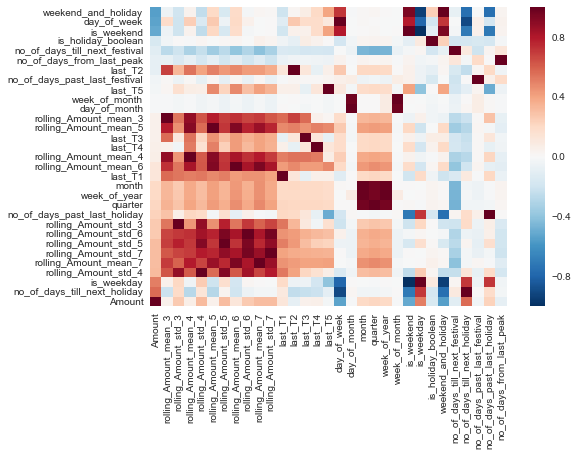

In [310]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(rolled_data3.corr().sort_values('Amount'))
plt.show()

In [311]:
corr_matrix = rolled_data3.corr()
corr_matrix["Amount"].sort_values(ascending=False)

Amount                           1.000000
no_of_days_till_next_holiday     0.562557
is_weekday                       0.510602
rolling_Amount_std_4             0.316513
rolling_Amount_mean_7            0.310386
rolling_Amount_std_7             0.309778
rolling_Amount_std_5             0.308025
rolling_Amount_std_6             0.263410
rolling_Amount_std_3             0.258150
no_of_days_past_last_holiday     0.228160
quarter                          0.212481
week_of_year                     0.203091
month                            0.195779
last_T1                          0.119672
rolling_Amount_mean_6            0.119005
                                   ...   
last_T4                          0.060369
last_T3                          0.054242
rolling_Amount_mean_5            0.049938
rolling_Amount_mean_3            0.047270
day_of_month                    -0.008964
week_of_month                   -0.011032
last_T5                         -0.025883
no_of_days_past_last_festival   -0

In [313]:
all_cols=rolled_data3.columns.tolist()

In [314]:
all_cols.remove('Amount')

In [315]:
rolled_data3.shape

(978, 32)

In [334]:
rolled_data3['time_since_for_trend']=rolled_data3['time_since_for_trend'].astype(int)

D:\python\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [335]:
train=rolled_data3[:-200]
test=rolled_data3[-200:]

In [336]:
import xgboost
best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.5,
                 gamma=1,                 
                 learning_rate=0.04,
                 max_depth=6,
                 n_estimators=250,                                                                    
                 seed=0)
best_xgb_model.fit(train[all_cols],train["Amount"])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=1, learning_rate=0.04, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

In [339]:
import math
from sklearn.metrics import mean_squared_error,mean_squared_log_error,mean_absolute_error

pred_val_xgb=best_xgb_model.predict(test[all_cols])
print(math.sqrt(mean_squared_error(test['Amount'],pred_val_xgb)))


1251431.6691975147
942.8482982224327


In [43]:
50/418

0.11961722488038277

In [42]:
amts['CustID_enc'].value_counts(normalize=True).cumsum().head(50)/418

387824    0.265700
888384    0.431636
900135    0.481831
365019    0.516961
761449    0.542621
421069    0.565947
591063    0.587310
149503    0.606265
517142    0.621750
430977    0.636403
924560    0.649510
783405    0.662494
391481    0.674537
180067    0.685481
466991    0.696139
123441    0.706533
198403    0.716663
352051    0.726731
747833    0.736797
805400    0.746288
352330    0.755672
399993    0.764854
343762    0.773692
491055    0.780368
697273    0.787032
704348    0.793513
883354    0.799861
278504    0.805510
615012    0.810600
791919    0.815619
796073    0.820611
224283    0.825282
502136    0.829866
917420    0.834438
683967    0.838991
423890    0.843477
203101    0.847877
438511    0.852162
121004    0.856331
826077    0.859957
207180    0.863514
711461    0.867033
515470    0.870535
835692    0.873954
507937    0.877275
277015    0.880518
888408    0.883735
586634    0.886866
455734    0.889758
657516    0.892538
Name: CustID_enc, dtype: float64

In [ ]:
amts.groupby(['Alpha Rec Code',]).

In [47]:
data['Receipt Number'].astype(str).apply(lambda x: '' if x=='76417510' else x).value_counts()

            353508
17533592        17
15234363        15
30773428        13
51178364        12
13816964        12
17818121        12
13653877        12
17008581        11
12841399        11
32250475        10
21043484        10
45111412         9
76420008         9
44278670         9
17305966         9
29440540         9
76423852         9
15664564         9
15084221         9
29302203         8
13996210         8
17777448         7
74919004         7
36606615         7
34382352         7
15037500         7
12033049         7
16754584         7
31941252         7
74676466         7
27396561         7
47840384         7
18979081         7
76435529         7
33683368         7
25209303         7
17594645         7
16310170         7
31293014         7
13965199         7
13482101         7
19467367         7
12700813         7
13966697         7
15353095         7
25622287         7
17813388         7
48138301         6
14751587         6
             ...  
53017149         1
26086807    

In [340]:
last_values=[16,32,11,19,28]

In [341]:
last_values.remove(last_values[0])

In [343]:
last_values.remove(last_values[0])
last_values.append(39)

In [345]:
last_values[0]

32

In [346]:
# test data feats creation